# 配置

In [1]:
settings = {
    "width": 256,
    "height": 256,
    'rotation_step': 30, # 旋转的粒度
    'scale': 0.05, # 每个像素的大小，单位：米
    'initial_grid': 1.0, # 枚举扫描位置时使用的初始间隔
    'ignore': 0.20,
    'threshold': 0.3,

    # 数据集位置
    "dataset": "../../../data/hm3d_minival/",
    "dataset_config": "../../../data/hm3d_minival/hm3d_annotated_minival_basis.scene_dataset_config.json", # Configuration of the dataset


    # 采样结果的储存位置
    "groundtruth_path": "../../../data/topdown/minival/",

    "sensor_height": 1.5,  # 传感器的高度，单位：米
    "enable_physics": False, 
}

# 运行全部

In [2]:
from utils import make_samples
import torch
import sys
from models.common import device
from models.perception.mapping.mapping import local_semantic_map

/home/wzj/anaconda3/envs/habitat/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Habitat

In [4]:
import habitat_sim

In [6]:
from models.perception.utils import (
    quaternion2radian, 
    depth_map_to_point_cloud, 
    rotate_point_cloud, 
    fall_on_map,
    ClassReducer,
    display_semantic_map
)

def look_around(relative_position: tuple, sim: habitat_sim.Simulator, global_map: torch.Tensor, reducer: ClassReducer, tmp:torch.Tensor=None):
    instance_map = []
    depth_map = []
    degrees = []

    for t in range(int(360 / settings['rotation_step'])):
        obs = sim.step('turn_right')
        instance_map.append(torch.tensor(obs['semantic_sensor'] * 1.0).to(device))
        depth_map.append(torch.tensor(obs['depth_sensor'] * 1.0).to(device))
        degrees.append(quaternion2radian(sim.get_agent(0).get_state().rotation))


    depth_map = torch.stack(depth_map)
    instance_map = torch.stack(instance_map)
    semantic_map = reducer.instance_to_category(instance_map)
    assert (semantic_map != reducer.recover(reducer.reduce(semantic_map))).sum() == 0
    semantic_map = reducer.reduce(semantic_map)
    degrees = torch.stack(degrees).to(device)

    fall_on_map(
        rotate_point_cloud(
            depth_map_to_point_cloud(
                depth_map,
                torch.tensor(-1.0).acos() / 2
            ),
            degrees
        ),
        semantic_map,
        global_map,
        relative_position,
        settings['scale'],
        tmp=tmp
    )



In [7]:
from torch.nn.functional import max_pool2d, avg_pool2d

def explore(sim, reducer: ClassReducer, global_semantic_map:torch.Tensor=None, tmp:torch.Tensor=None):
    with torch.no_grad():
        height = sim.pathfinder.get_bounds()[0][1]
        bounds = sim.pathfinder.get_bounds()[0]
        bounds = torch.tensor([bounds[2],bounds[0]]).to(device).flatten()

        nav_mesh = torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height)).to(device)
        for t in range(10):
            nav_mesh = nav_mesh | torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height + t * 0.1)).to(device)
        for t in range(10):
            nav_mesh = nav_mesh | torch.tensor(sim.pathfinder.get_topdown_view(settings['scale'], height - t * 0.1)).to(device)

        if global_semantic_map is None:
            global_semantic_map = torch.zeros([reducer.get_reduced_class_number()] + list(nav_mesh.shape)).to(device)
        if tmp is None:
            tmp = torch.zeros(global_semantic_map.shape).to(device)

        grid = settings['initial_grid']
        count = 0
        while True:
            grid_px = int(grid / settings['scale'])
            if grid_px <= 1 or grid_px <= settings['ignore'] / settings['scale']:
                break

            ys, xs = torch.arange(0, nav_mesh.shape[0]).to(device), torch.arange(0, nav_mesh.shape[1]).to(device)
            ys, xs = ys.unsqueeze(dim=1).expand(-1, nav_mesh.shape[1]), xs.unsqueeze(dim=0).expand(nav_mesh.shape[0], -1)
            coords, ys, xs = torch.stack([ys, xs], dim=0).type(torch.float) + 0.5, None, None
            # coords 目前是像素坐标
            coords = coords * nav_mesh.unsqueeze(dim=0)
            navigatable = (max_pool2d(nav_mesh.unsqueeze(dim=0).type(torch.float), kernel_size=grid_px) > 0).reshape(-1)
            coords = avg_pool2d(coords, kernel_size=grid_px).reshape(2, -1)[:, navigatable] / avg_pool2d(nav_mesh.unsqueeze(dim=0).type(torch.float), kernel_size=grid_px).reshape(-1)[navigatable]
            # coords 目前包含所有可导航的粗像素的可导航中心

            coarse_semantic_map = (avg_pool2d(global_semantic_map.max(dim=0)[0].unsqueeze(dim=0).clamp(max=1), kernel_size=grid_px) > settings['threshold']).squeeze(dim=0)
            coords = coords[:, ~coarse_semantic_map.reshape(-1)[navigatable]]
            # coords 目前包含所有可导航且不满足要求的粗像素的可导航中心


            coords = coords * settings['scale']
            coords = coords.transpose(0, 1)
            abs_coords = coords + bounds

            if len(coords) == 0 or count >= 10:
                print(f"grid={grid}m done")
                grid /= 2
                continue
            count += 1

            for i in tqdm(range(len(coords)), f'grid={grid:.3f}m'):
                pos = sim.pathfinder.get_random_navigable_point_near(
                    [abs_coords[i][1].item(), height, abs_coords[i][0].item()], 
                    radius=settings['scale'] * grid_px
                )
                if not sim.pathfinder.is_navigable(pos):
                    continue

                state = habitat_sim.AgentState(
                    position=pos,
                    rotation=sim.get_agent(0).get_state().rotation
                )
                sim.get_agent(0).set_state(state=state, reset_sensors=False)
                sim.step('turn_left')

                pos = sim.get_agent(0).get_state().position
                pos = torch.tensor([pos[2], pos[0]]).to(device)
                relative_pos = pos - bounds
                look_around(
                    relative_pos,
                    sim,
                    global_semantic_map,
                    reducer,
                    tmp=tmp
                )
        return global_semantic_map, nav_mesh


In [8]:
def save_scene(scene_name: str, global_semantic_map: torch.Tensor, reducer: ClassReducer):
    path = os.path.join(settings['groundtruth_path'], scene_name)
    torch.save(global_semantic_map, path + '.gsm')
    reducer.save(path + '.reducer')

def explore_scene(scene_dir:str, scene_name:str=None):
    if scene_name is None:
        scene_name = scene_dir[scene_dir.find('-') + 1:]
    cfg = make_cfg(scene_dir, scene_name)
    sim = habitat_sim.Simulator(cfg)

    reducer = ClassReducer.from_sim(sim) 
    global_semantic_map, nav_mesh = explore(sim, reducer)

    display_semantic_map(global_semantic_map)
    display_map(nav_mesh.cpu().numpy())
    save_scene(scene_name, global_semantic_map, reducer)

    sim.close()

  0%|          | 0/4 [00:00<?, ?it/s]

00800-TEEsavR23oF
{'book', 'door handle', 'cabinet', 'magazine', 'electrical controller', 'window curtain', 'microwave', 'kitchen countertop item', 'wall hanging decoration', 'floor mat', 'folder', 'trashcan', 'chair', 'backpack', 'chandelier', 'telephone', 'fireplace', 'fruit bowl', 'shower curtain', 'desk lamp', 'bathroom accessory', 'iron', 'sink', 'toilet paper', 'led tv', 'bottle of soap', 'pillar', 'tissue box', 'stack of papers', 'ceiling', 'couch', 'soap bottle', 'lamp', 'wall', 'plant', 'sheet', 'shirt', 'bag', 'case', 'table lamp', 'oven and stove', 'curtain rod', 'alarm', 'coffee machine', 'refrigerator', 'decorative plate', 'toilet brush', 'nightstand', 'speaker', 'flower', 'mat', 'bed', 'bath mat', 'plush toy', 'picture', 'kitchen cabinet', 'worktop', 'towel', 'iron board', 'frame', 'shower dial', 'mirror', 'casket', 'pad', 'toilet', 'knife holder', 'pc tower', 'curtain', 'fire alarm', 'newspaper', 'doormat', 'clothes hanger rod', 'kitchen appliance', 'window', 'boxes', 'b

[22:21:37:265302]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


grid=1.0m done
grid=0.5m done
grid=0.25m done


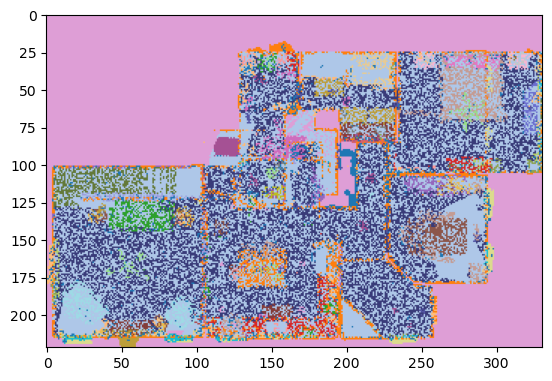

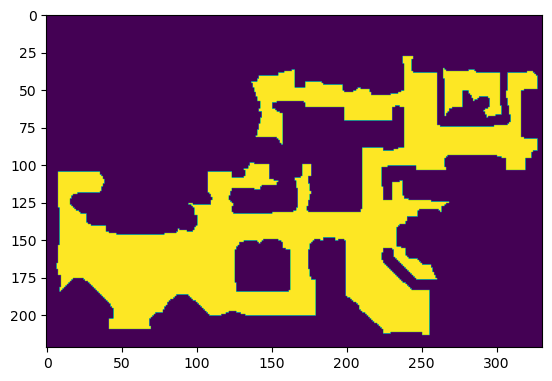

 25%|██▌       | 1/4 [00:18<00:54, 18.09s/it]

00803-k1cupFYWXJ6
{'sofa', 'exhibition picture', 'curtain', 'ceiling arch', 'fire alarm', 'ship model', 'ceiling support', 'exhibition table', 'wall', 'banister', 'bust', 'window', 'air vent', 'crate', 'table', 'pipe', 'ceiling ladder', 'door', 'table lamp', 'stained glass', 'device', 'framed text', 'ceiling lamp', 'stairs', 'exhibition window frame', 'window frame', 'elevator door', 'ceiling under stairs', 'ceiling lower', 'statue', 'information', 'chair', 'door frame', 'ledge', 'entrance arch', 'map', 'chassis', 'flag', 'carpet', 'armchair', 'arcade', 'bin', 'decorative plant', 'arch', 'coffee table', 'bench', 'ceiling decorative lamp', 'sewing machine', 'picture', 'exhibition panel', 'door window', 'exhibition window', 'fire detector', 'decoration', 'Unknown', 'sign', 'radiator', 'unknown', 'floor', 'ceiling boarder', 'step', 'ceiling', 'wall lamp', 'door knob'}
reduced number of classes: 64 possible total class number: 63


[22:21:58:942549]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[22:21:58:943271]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[22:21:59:568814]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[22:21:59:569031]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[22:22:00:174416]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
[22:22:00:17476

grid=1.0m done
grid=0.5m done
grid=0.25m done


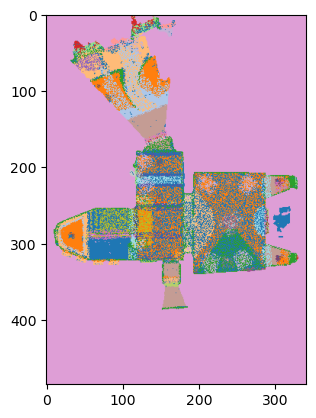

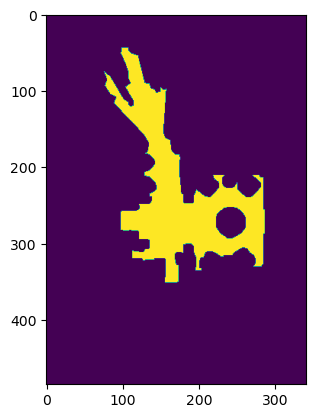

 50%|█████     | 2/4 [00:37<00:37, 18.59s/it]

00808-y9hTuugGdiq
{'sofa', 'thermostat', 'shower floor', 'whine shelf', 'cabinet', 'banister', 'light fixture', 'towel ring', 'washer-dryer', 'microwave', 'jar', 'ice maker', 'sideboard', 'broom', 'shelf', 'kitchen counter', 'vacuum cleaner', 'shower rod', 'statue', 'chair', 'telephone', 'kettle', 'utensil', 'fireplace', 'flower vase', 'rug', 'closet mirror wall', 'sink', 'toilet paper', 'glass', 'fire extinguisher', 'pillar', 'ceiling', 'bathtub platform', 'soap bottle', 'lamp', 'wall', 'shower cabin', 'plant', 'curtain rod', 'umbrella', 'coffee maker', 'shower knob', 'stereo', 'shelving', 'refrigerator', 'toilet brush', 'nightstand', 'bath cabinet', 'bed', 'picture', 'cushion', 'hook', 'kitchen cabinet', 'towel', 'shower dial', 'ladder', 'bathtub', 'mirror', 'surface', 'blinds', 'stool', 'remote control', 'toilet', 'knife holder', 'ornament', 'freezer', 'showerhead', 'curtain', 'surfboard', 'paper towel', 'hanger', 'window', 'shower seat', 'table tennis table', 'ventilation hood', 't

[22:22:16:007993]:[Nav] PathFinder.cpp(1029)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint.  Try increasing max tries if the navmesh is fine but just hard to sample from
grid=1.000m: 100%|██████████| 85/85 [00:06<00:00, 12.99it/s]


grid=1.0m done


grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 2866.92it/s][22:22:21:102815]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius

[22:22:21:109889]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 6502.80it/s]
[22:22:21:114889]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
[22:22:21:119524]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 2142.14it/s]
[22:22:21:123787]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 2082.57it/s]
[22:22

grid=0.5m done
grid=0.25m done


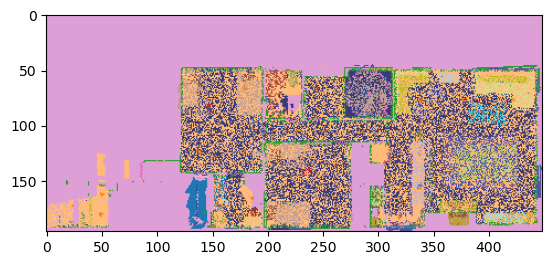

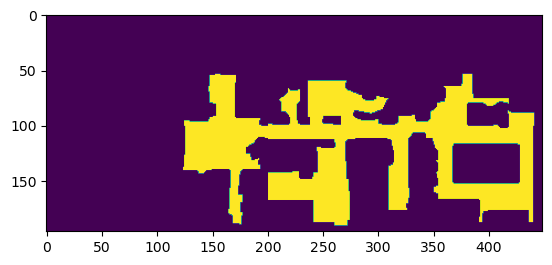

 75%|███████▌  | 3/4 [00:55<00:18, 18.39s/it]

00802-wcojb4TFT35
{'sofa', 'book', 'cabinet', 'bathtub tap', 'closet door', 'attic hatch', 'folding chair', 'control panel', 'tool box', 'box of food', 'microwave', 'pipe', 'jar', 'watering can', 'can', 'shelf', 'folder', 'pendant', 'stair', 'vacuum cleaner', 'trashcan', 'cup', 'chair', 'tray', 'backpack', 'ball', 'bags', 'boards', 'fireplace', 'alarm clock', 'shower curtain', 'flower vase', 'shredder', 'luggage', 'toy', 'garage door opener railing', 'rug', 'light switch', 'heater', 'food', 'rack with shoes', 'shower door', 'board games', 'spice rack', 'sink', 'glass', 'drawers', 'bicycle helmets', 'football', 'cloth hangers', 'sewing box', 'beam', 'pot', 'ceiling', 'liquid container', 'sleeping bag', 'clothes hanger', 'footrest', 'sliding door', 'lamp', 'car', 'wall', 'cloth hanger', 'air vent', 'bag', 'case', 'kitchen utensils', 'art frame', 'cross', 'toilet paper dispenser', 'curtain rod', 'fruit', 'coffee machine', 'plumbing', 'cleaning clutter', 'piano bench', 'refrigerator', 'wat

grid=1.000m: 100%|██████████| 78/78 [00:05<00:00, 13.01it/s]


grid=1.0m done


grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 2706.00it/s][22:22:37:904936]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius

[22:22:37:911775]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 1334.07it/s]
[22:22:37:916856]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 1394.38it/s]
[22:22:37:921315]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0.500m: 100%|██████████| 1/1 [00:00<00:00, 2164.24it/s]
[22:22:37:925981]:[Nav] PathFinder.cpp(1014)::getRandomNavigablePointAroundSphere : Failed to getRandomNavigablePoint. No polygon found within radius
grid=0

grid=0.5m done
grid=0.25m done


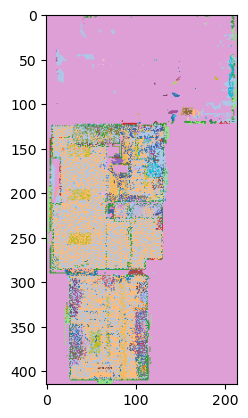

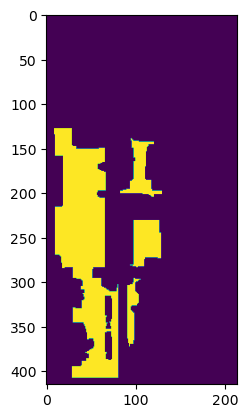

100%|██████████| 4/4 [01:11<00:00, 18.00s/it]


In [10]:
make_samples(settings, explore_scene)